# Notebook for plotting individual blocks of data 

Have to input the filename and block number you want to inspect. Program then automatically finds best dm from the corresponding .dat file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedispersion
import filterbankio_headerless
import matplotlib

%matplotlib inline

In [2]:
# watermark
BASE_DATA_PATH = '/oxford_data/FRBSurvey/Archive/'
fb_filename = 'Beam2_fb_D20170206T014224.fil'
dm_filename = fb_filename[:6] + 'dm' + fb_filename[8:25] + '.dat'
lofarFil = BASE_DATA_PATH + fb_filename
lofarDM = BASE_DATA_PATH + dm_filename

### LOFAR RADAR Event

In [3]:
# Read in the data using Filterbank class
fil = filterbankio_headerless.Filterbank(lofarFil)
timeFactor = 64
freqFactor = 8

tInt = fil.my_header[5] # set tInt

print(fil.my_header)

freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)
waterfall = waterfall.reshape(int(waterfall.shape[0]/timeFactor), timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

Enter a block number: 1038
[148.9, -0.00305176, 4, 1920, 1, 0.00032768]


In [4]:
# Get the best dm from the .dat file
content = open(lofarDM).read()
content = content.split('# ------')[-1].split('Done')[:-1]
NumberOfBlocks = len(content)
for x in content:
    if content.index(x) == fil.block_number - 1:
        events = x.split('#')
        bufStr = events[-1]
        BestDM = float(bufStr.split('|')[2].split(' ')[-2])
    else:
        pass
print('Best DM is ',BestDM)

Best DM is  9.3000001907349


In [5]:
dm = BestDM

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], int(waterfall.shape[1]/freqFactor), freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], int(ddwaterfall.shape[1]/freqFactor), freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [6]:
# Take the first 8 seconds of data
start_time = 0.0
time_window = 8.

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [7]:
# flatten bandpass
bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#waterfallNorm = waterfall - bandpass
waterfallNorm = waterfall

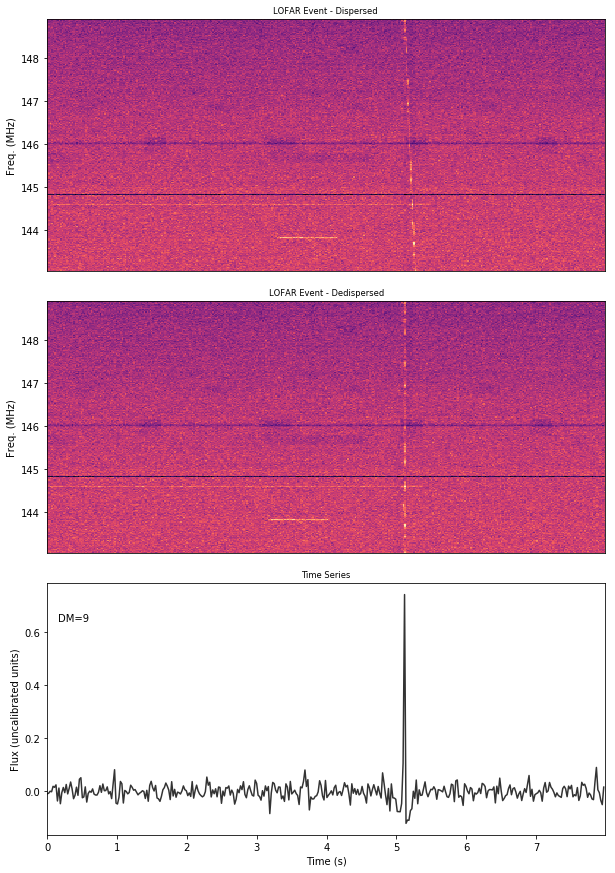

In [9]:
cmap = 'magma'

fig = plt.figure(figsize=(10,15)) # (width, height)

gs = matplotlib.gridspec.GridSpec(3,3)
gs.update(hspace=0.12, wspace=0.0)

# Dispersed Frequency plot
ax1 = plt.subplot(gs[0:1,0:3])
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('Freq. (MHz)')
plt.title('LOFAR Event - Dispersed ', fontdict={'fontsize':'small'})
ax1.get_xaxis().set_visible(False)

# Dedispersed Frequency plot
ax2 = plt.subplot(gs[1:2,0:3])
imRawdd = plt.imshow(np.flipud(ddwaterfall.T), extent=(0, tInt*ddwaterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('Freq. (MHz)')
plt.title('LOFAR Event - Dedispersed', fontdict={'fontsize':'small'})
ax2.get_xaxis().set_visible(False)

# Time Series Plot
ax3 = plt.subplot(gs[2:3,0:3])
lineColor = 'k'
plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt*timeSeries.shape[0])
plt.text(0.02, 0.85, 'DM=%0.f'%dm, transform=ax3.transAxes)
plt.title('Time Series', fontdict={'fontsize':'small'})
plt.xlabel('Time (s)')
plt.ylabel('Flux (uncalibrated units)')

# Save plots to TrainingPlots directory
saveDir = 'TrainingPlots/'
saveName = dm_filename[:25] + '_block' + str(fil.block_number)
savePath = saveDir + saveName + '.png'
plt.savefig(savePath)

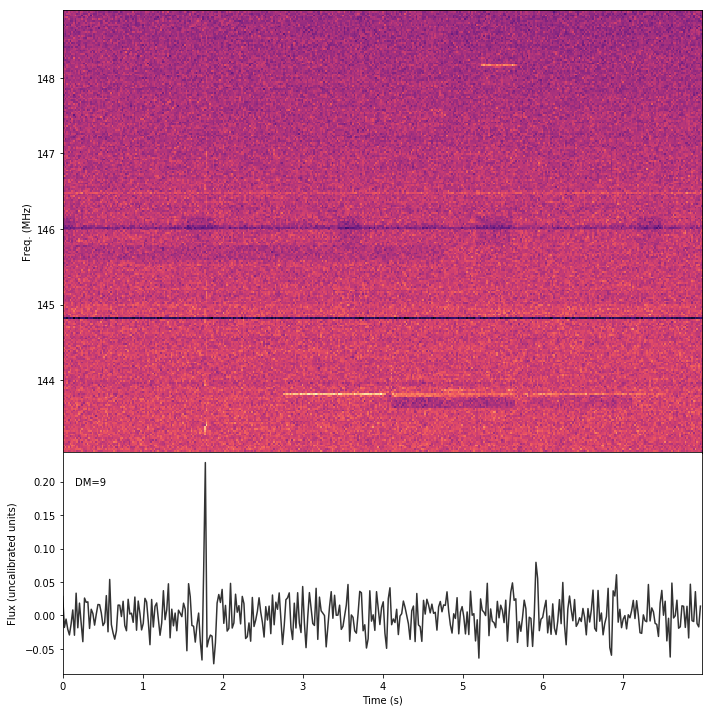

In [9]:
cmap = 'magma'

fig = plt.figure(figsize=(10,10)) # (width, height)

gs = matplotlib.gridspec.GridSpec(3,3)
gs.update(hspace=0.0, wspace=0.0)

ax1 = plt.subplot(gs[0:2,0:3])

imRaw = plt.imshow(np.flipud(ddwaterfall.T), extent=(0, tInt*ddwaterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('ARTEMIS Event (t: %i f: %i)'%(timeFactor, freqFactor))
plt.ylabel('Freq. (MHz)')
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot(gs[2:3,0:3])
lineColor = 'k'
plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt*timeSeries.shape[0])
#plt.title('Time Series (DM=%0.f)'%dm)
#plt.title('DM=%0.f'%dm)
plt.text(0.02, 0.85, 'DM=%0.f'%dm, transform=ax2.transAxes)
plt.xlabel('Time (s)')
plt.ylabel('Flux (uncalibrated units)', labelpad=8)

plt.tight_layout()

#plt.savefig('../figures/LOFAR_dynamic_dedisp.pdf')